In [1]:
import json
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.compiler import transpile

from diskit_updated.circuit_remapper import *
from ionq.compile_native import compile_to_ionq_native_gates

In [2]:
with open("error_datasheets/Triangulum_SpinQ_3qubits.json", 'r') as f:
    spinq_3q_datasheet = json.load(f)

with open("error_datasheets/Harmony_IonQ_11qubits.json", 'r') as f:
    ionq_11q_datasheet = json.load(f)
with open("error_datasheets/Aria1_IonQ_25qubits.json", 'r') as f:
    ionq_25q_datasheet = json.load(f)
with open("error_datasheets/Forte1_IonQ_36qubits.json", 'r') as f:
    ionq_36q_datasheet = json.load(f)

with open("error_datasheets/IBM_Kyiv_127qubits.json", 'r') as f:
    ibm_kyiv_127q_datasheet = json.load(f)

In [3]:
# GENERAL GATES
measure_gate = 'measure'
reset_gate = 'reset'

# 1. IONQ -> Only valid gates are:
#   - GPI: Puerta IonQ GPi
#   - GPI2: Puerta IonQ GPi2.
#   - MS: Puerta IonQ de Mølmer-Sørenson.

#GPI = Rz(2ϕ)X
#GPI2 = Rz(ϕ)Rx(π/2)Rz(−ϕ)
ionq_predecomposition_gates = ["id", "rx", "ry", "rz", "cx"]
ionq_valid_1qgates = ['gpi', 'gpi2']
ionq_valid_2qgates = ['ms']
ionq_valid_gates = ionq_valid_1qgates + ionq_valid_2qgates

# 2. IBMQ Kyiv -> ECR, ID, RZ, SX, X
ibmq_valid_1qgates = ["id", "rz", "sx", "x"]
ibmq_valid_2qgates = ["ecr"]
ibmq_valid_gates = ibmq_valid_1qgates + ibmq_valid_2qgates

# 3. SpinQ -> ID, H, X, Y, Z, SX, SY, SZ, RX, RY, RZ, T, TDG, S, SDG, CX, CY, CZ
spinq_valid_1qgates = ["id", "h", "x", "sx", "y", "z", "rx", "ry", "rz", "t", "tdg", "s", "sdg"]
spinq_valid_2qgates = ["cx", "cy", "cz"]
spinq_valid_gates = spinq_valid_1qgates + spinq_valid_2qgates

# CIRCUIT TO SIMULATE

In [4]:
import math
from shor.shor import Shor

def initialize_circuit(qregs = None, n_qubits = None):
    if qregs is None:
        return QuantumCircuit(n_qubits)
    
    qregs_list = qregs.values()
    return QuantumCircuit(*qregs_list)


def get_circuit_max2qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)
    q_circuit.cx(0, 1)

    return q_circuit
    # WRITE CODE HERE

# DISTRIBUTED UTILITIES

In [5]:
def create_distributed_topology(n_nodes, qubits_per_qnode):
    circuit_topo = Topology()
    circuit_topo.create_qmap(n_nodes, [qubits_per_qnode for _ in range(n_nodes)], "qnode")

    qregs = {}

    for qpu in circuit_topo.qmap:
        reg = circuit_topo.qmap[qpu][0]._register
        qregs[reg.name] = reg
    for qpu in circuit_topo.emap:
        reg = circuit_topo.emap[qpu]._register
        qregs[reg.name] = reg
    
    return circuit_topo, qregs

In [6]:
def remap_circuit(qc, circuit_topo, qregs, decompose_list=None, measure=False):
    remapper = CircuitRemapper(circuit_topo)
    if decompose_list is None:
        dist_circ = remapper.remap_circuit(qc)
    else:
        dist_circ = remapper.remap_circuit(qc, decompose=True, decompose_list=decompose_list)

    if measure:
        measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
        measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
        dist_circ.add_register(measure_reg_q0)
        dist_circ.add_register(measure_reg_q1)
        #dist_circ.barrier()
        dist_circ.measure(qregs['qnode0'], measure_reg_q0)
        dist_circ.measure(qregs['qnode1'], measure_reg_q1)

    return dist_circ

# ANALISIS CIRCUITOS

- Calculo de la fidelidad total

In [7]:
import math

def calculate_total_fidelity(
    count_operations: OrderedDict, 
    op_list_1q: list[str], 
    op_list_2q: list[str],
    config_json: dict[str, object]
) -> float:
    
    #total_error = 0
    total_fidelity = 1.0
    fidelity_config = config_json["fidelity"]

    for op_1q in op_list_1q:
        if op_1q in count_operations:
            #total_error += count_operations[op_1q] * (1 - fidelity_config['1Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['1Q']['mean'], count_operations[op_1q])

    for op_2q in op_list_2q:
        if op_2q in count_operations:
            #total_error += count_operations[op_2q] * (1 - fidelity_config['2Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['2Q']['mean'], count_operations[op_2q])

    if measure_gate in count_operations:
        #total_error += count_operations[measure_gate] * (1 - fidelity_config['readout']['mean'])
        total_fidelity *= math.pow(fidelity_config['readout']['mean'], count_operations[measure_gate])

    #return 1 - total_error
    return total_fidelity

- Benchmark de diferentes máquinas y algoritmos:

In [8]:
from itertools import permutations

def compute_metrics(
    count_operations: OrderedDict,
    machine_type_config: dict[str, object],

):
    if machine_type_config["machine"] == "ionq":
        fidelity = calculate_total_fidelity(count_operations, ionq_valid_1qgates, 
                                            ionq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "ibmq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "spinq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    
    return fidelity


def benchmark_distributed_execution(
    benchmark_machine_list: list[tuple[dict[str, object], int, int]],
    circuit_function,
    saved_counts: list[OrderedDict] = None
):
    dist_circuits = []
    output_circuits = []

    qubits_list = []
    fidelity_list = []
    duration_list = []

    for idx, (machine_type_config, n_qnodes, qubits_per_qnode) in enumerate(benchmark_machine_list):
        if saved_counts is not None and idx < len(saved_counts):
            fidelity = compute_metrics(saved_counts[idx], machine_type_config)
        else:
            print(f"* Starting analysis with {machine_type_config['machine']} - {n_qnodes} qnodes - {qubits_per_qnode} qubits per qnode:")
            if machine_type_config["machine"] == "ionq":
                decompose_list = ionq_predecomposition_gates
            else:
                decompose_list = ibmq_valid_gates

            if n_qnodes == 1:
                dist_circuit = circuit_function(n_qubits=qubits_per_qnode)
            else:
                circuit_topo, qregs = create_distributed_topology(n_nodes=n_qnodes, qubits_per_qnode=qubits_per_qnode)
                initial_circuit = circuit_function(qregs=qregs)

                # Es necesario antes de remapear el circuito transpilarlo a puertas basicas
                # (para descomponer puertas de más de 2 qubits)
                print("\t- Initializing distributed mapping...")
                initial_circuit = transpile(initial_circuit, basis_gates=decompose_list)
                # Remapeamos el circuito a formato distribuido
                print("\t- Remapping circuit...")
                dist_circuit = remap_circuit(qc=initial_circuit, circuit_topo=circuit_topo, qregs=qregs)
            
            print("\t-Executing final compilation...")
            if machine_type_config["machine"] == "ionq":
                output_ionq_circuit = compile_to_ionq_native_gates(dist_circuit, check=False)

                ionq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ionq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ionq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(output_ionq_circuit, basis_gates=ionq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ionq_instruction_durations)
            elif machine_type_config["machine"] == "ibmq":
                ibmq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ibmq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ibmq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=ibmq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ibmq_instruction_durations)
                
            elif machine_type_config["machine"] == "spinq":
                spinq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in spinq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in spinq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=spinq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=spinq_instruction_durations)

            print(f"Duration: {output_circuit.duration}")
            
            duration_list.append(output_circuit.duration)
            dist_circuits.append(dist_circuit)
            output_circuits.append(output_circuit)
            count_operations = output_circuit.count_ops()
            print("Operations:", count_operations)
        
            fidelity = compute_metrics(count_operations, machine_type_config)
        
        fidelity_list.append(fidelity)
        qubits_list.append(qubits_per_qnode)
            
    return dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list

# EXECUTION SPINQ AND IONQ MACHINES WITH 10 QUBIT ALGORITHM

In [9]:
dist_circuits_10q, output_circuits_10q, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 2, 1), 
        (ionq_11q_datasheet, 2, 1),
        (ionq_25q_datasheet, 2, 1),
        (ionq_36q_datasheet, 2, 1),
        (ibm_kyiv_127q_datasheet, 2, 1),
        (spinq_3q_datasheet, 1, 2), 
        (ionq_11q_datasheet, 1, 2),
        (ionq_25q_datasheet, 1, 2),
        (ionq_36q_datasheet, 1, 2),
        (ibm_kyiv_127q_datasheet, 1, 2),
    ],
    circuit_function=get_circuit_max2qubits,
)

with open("output/2q_cnot.json", "w") as outfile:
    json.dump({
        "duration": duration_list,
        "fidelity": fidelity_list
    }, outfile)

* Starting analysis with spinq - 2 qnodes - 1 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0007016
Operations: OrderedDict([('delay', 8), ('cx', 3), ('measure', 2), ('reset', 2), ('x', 2), ('rz', 1), ('h', 1), ('s', 1), ('ry', 1), ('z', 1)])
* Starting analysis with ionq - 2 qnodes - 1 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0006500000000000002
Operations: OrderedDict([('gpi2', 14), ('delay', 6), ('gpi', 3), ('ms', 3), ('measure', 2), ('reset', 2)])
* Starting analysis with ionq - 2 qnodes - 1 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.00287
Operations: OrderedDict([('gpi2', 14), ('delay', 6), ('gpi', 3), ('ms', 3), ('measure', 2), ('reset', 2)])
* Starting analysis with ionq - 2 qnodes - 1 qubits per qnode:
	- Initializing distributed mapp

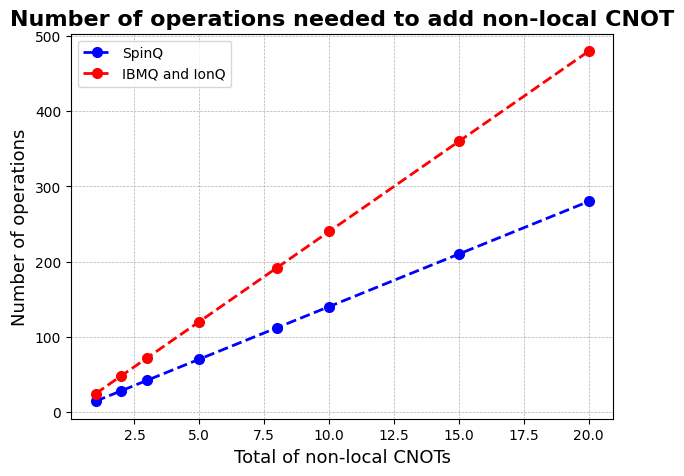

In [10]:
labels = ["SpinQ", "IBMQ and IonQ"]

operations_non_local = [14, 24]
n_operations = np.array([1, 2, 3, 5, 8, 10, 15, 20])

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Configuración del gráfico
ax.plot(n_operations, n_operations * operations_non_local[0], color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[0])
ax.plot(n_operations, n_operations * operations_non_local[1], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[1])

# Títulos y etiquetas
ax.set_title('Number of operations needed to add non-local CNOT', fontsize=16, fontweight='bold')
ax.set_xlabel('Total of non-local CNOTs', fontsize=13)
ax.set_ylabel('Number of operations', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

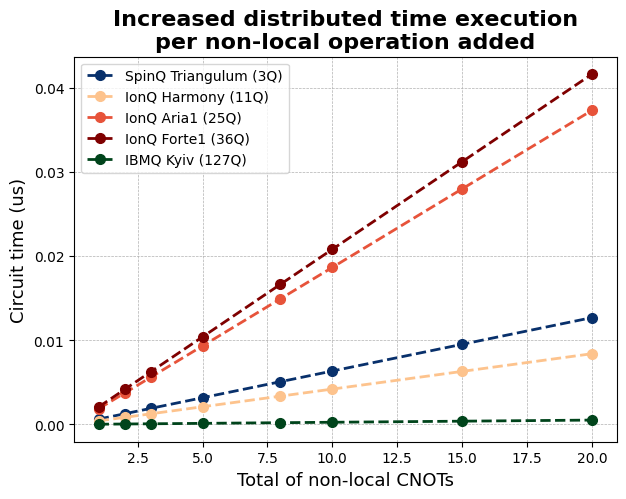

In [19]:
import matplotlib as mpl

labels = ["SpinQ Triangulum (3Q)", "IonQ Harmony (11Q)", "IonQ Aria1 (25Q)", "IonQ Forte1 (36Q)", "IBMQ Kyiv (127Q)"]

cm_b = mpl.colormaps['Blues'].resampled(4)
cm_r = mpl.colormaps['OrRd'].resampled(4)
cm_g = mpl.colormaps['Greens'].resampled(4)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Configuración del gráfico
ax.plot(n_operations, n_operations * (duration_list[0] - duration_list[5]), color=cm_b(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[0])
ax.plot(n_operations, n_operations * (duration_list[1] - duration_list[6]), color=cm_r(0.45), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[1])
ax.plot(n_operations, n_operations * (duration_list[2] - duration_list[7]), color=cm_r(0.6), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[2])
ax.plot(n_operations, n_operations * (duration_list[3] - duration_list[8]), color=cm_r(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[3])
ax.plot(n_operations, n_operations * (duration_list[4] - duration_list[9]), color=cm_g(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[4])

# Títulos y etiquetas
ax.set_title('Increased distributed time execution\nper non-local operation added', fontsize=16, fontweight='bold')
ax.set_xlabel('Total of non-local CNOTs', fontsize=13)
ax.set_ylabel('Circuit time (us)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

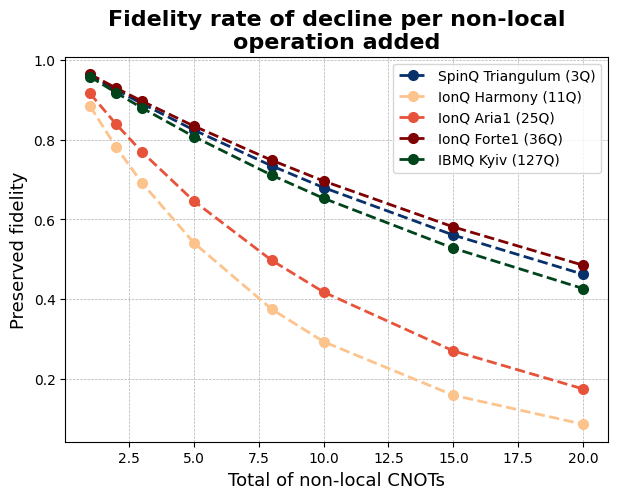

In [21]:
import matplotlib as mpl

labels = ["SpinQ Triangulum (3Q)", "IonQ Harmony (11Q)", "IonQ Aria1 (25Q)", "IonQ Forte1 (36Q)", "IBMQ Kyiv (127Q)"]

cm_b = mpl.colormaps['Blues'].resampled(4)
cm_r = mpl.colormaps['OrRd'].resampled(4)
cm_g = mpl.colormaps['Greens'].resampled(4)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Configuración del gráfico
ax.plot(n_operations, (1 - (fidelity_list[5] - fidelity_list[0]))**n_operations, color=cm_b(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[0])
ax.plot(n_operations, (1 - (fidelity_list[6] - fidelity_list[1]))**n_operations, color=cm_r(0.45), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[1])
ax.plot(n_operations, (1 - (fidelity_list[7] - fidelity_list[2]))**n_operations, color=cm_r(0.6), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[2])
ax.plot(n_operations, (1 - (fidelity_list[8] - fidelity_list[3]))**n_operations, color=cm_r(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[3])
ax.plot(n_operations, (1 - (fidelity_list[9] - fidelity_list[4]))**n_operations, color=cm_g(0.9), marker='o', linestyle='dashed', linewidth=2, markersize=7, label=labels[4])

# Títulos y etiquetas
ax.set_title('Fidelity rate of decline per non-local\noperation added', fontsize=16, fontweight='bold')
ax.set_xlabel('Total of non-local CNOTs', fontsize=13)
ax.set_ylabel('Preserved fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# SPINQ CIRCUIT:

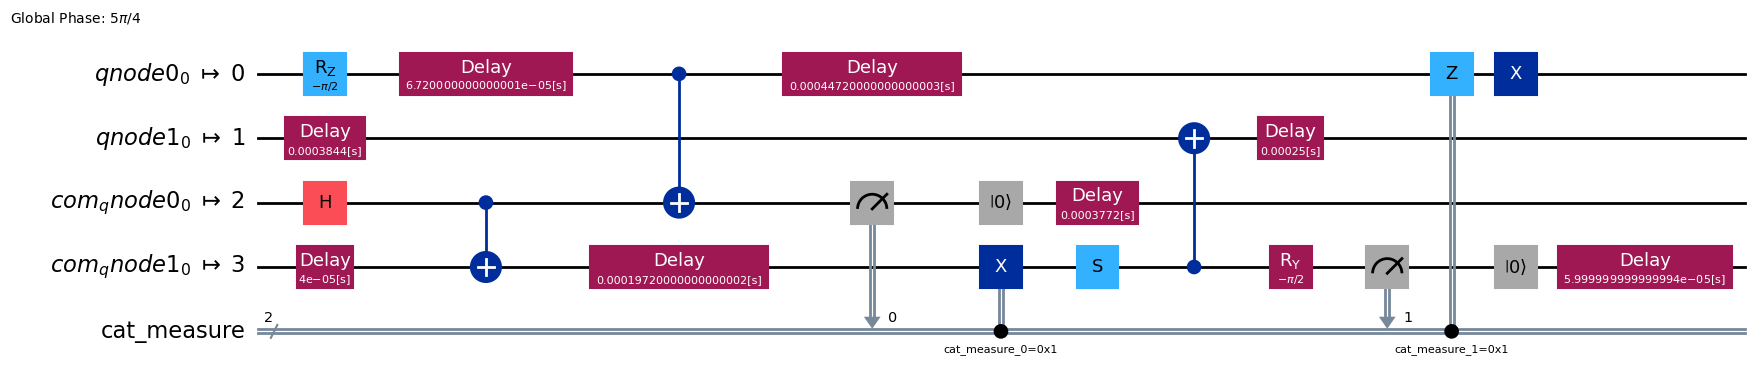

In [13]:
output_circuits_10q[0].draw('mpl')

# IONQ CIRCUIT:

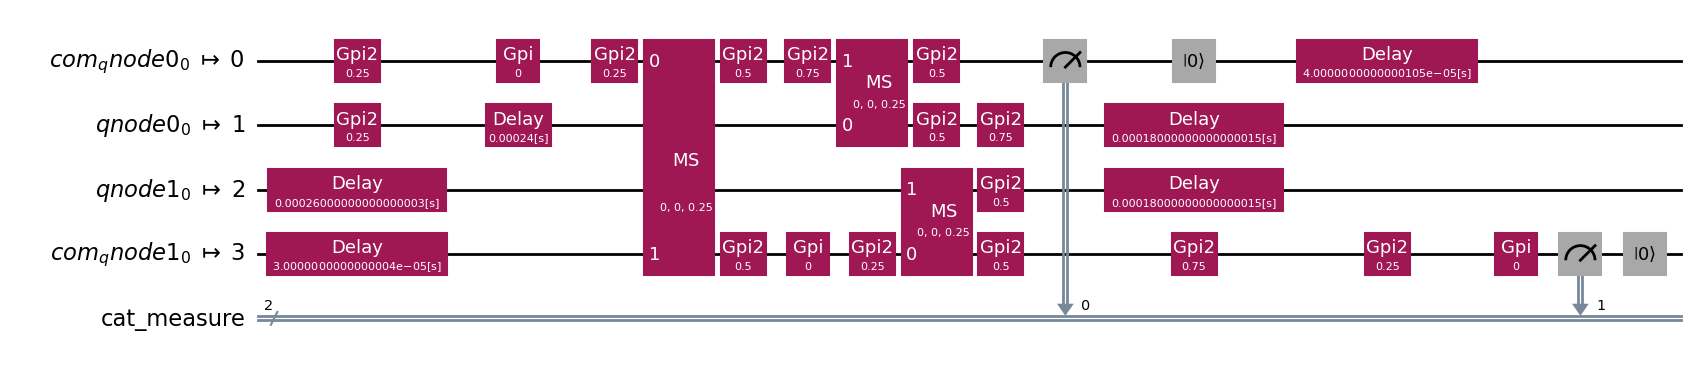

In [14]:
output_circuits_10q[1].draw('mpl')

# IBM CIRCUIT:

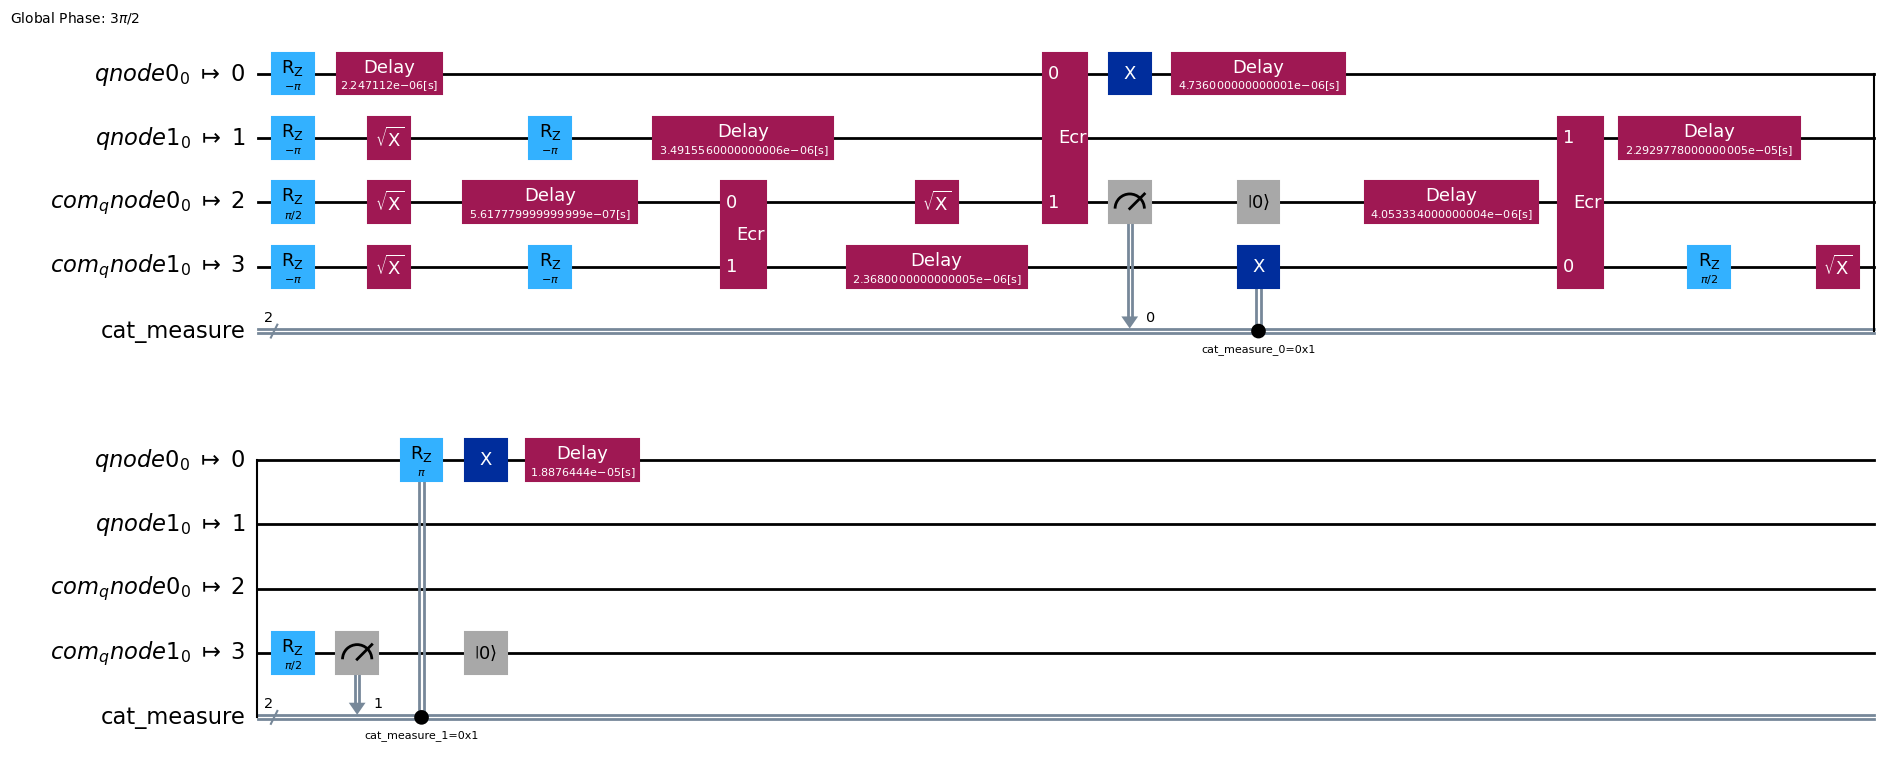

In [15]:
output_circuits_10q[4].draw('mpl')

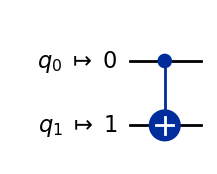

In [16]:
output_circuits_10q[5].draw('mpl')